# RELA Modisco Run \#1 (Sep 6, 2018) Description:

- For training, we used stride 10 across the union of positives and stride 1000 in the background. For the validation set where the results are reported on, we used uniform stride 50 across chr2
- 4 tasks:
    ```
    GM12878-JUND-human-ENCSR000EYV-optimal_idr.narrowPeak.gz
    GM12878-JUND-human-ENCSR000DYS-optimal_idr.narrowPeak.gz
    GM12878-RELA-human-ENCSR000EAG-optimal_idr.narrowPeak.gz
    GM12878-SPI1-human-ENCSR000BGQ-optimal_idr.narrowPeak.gz
    GM12878-STAT1-human-ENCSR332EYT-optimal_idr.narrowPeak.gz
    ```
- Used `target_fdr=0.01`
- Ran deeplift/modisco on 1k around the summit
- 24587 identified in total
```
9 activity patterns with support >= 100 out of 243 possible patterns
Metacluster sizes:  16226, 3951, 1437, 1008, 567, 472, 431, 267, 190
Idx to activities:  {0: '0,0,0,1,0', 1: '1,1,0,1,0', 2: '1,0,0,1,0', 3: '0,0,1,1,0', 4: '0,0,0,0,1', 5: '0,0,1,0,0', 6: '1,1,1,0,0', 7: '1,1,0,0,0', 8: '0,1,0,1,0'}
```
- With newly-added default `min_seqlets_per_task=500` for determining laplace threshold (got enough seqlets though)

In [1]:
from __future__ import print_function, division
%matplotlib inline


import os

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError: 
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import h5py

2.7.15 |Anaconda, Inc.| (default, May  1 2018, 23:32:55) 
[GCC 7.2.0]


Using cuDNN version 7001 on context None
Mapped name None to device cuda0: GeForce GTX TITAN X (0000:08:00.0)


laplace for the tasks:
![laplace_b 0](figures/laplace_0.png)
![laplace_b 1](figures/laplace_1.png)
![laplace_b 2](figures/laplace_2.png)
![laplace_b 3](figures/laplace_3.png)
![laplace_b 4](figures/laplace_4.png)


[logs](logs/modisco.txt)



Metaclusters heatmap


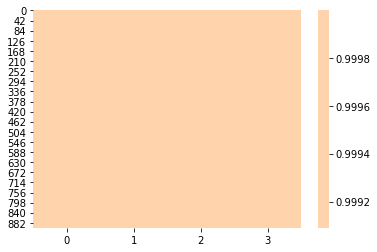

metacluster_0
activity pattern: [1 1 1 1]
metacluster_0 pattern_0
total seqlets: 789
Task 0 hypothetical scores:


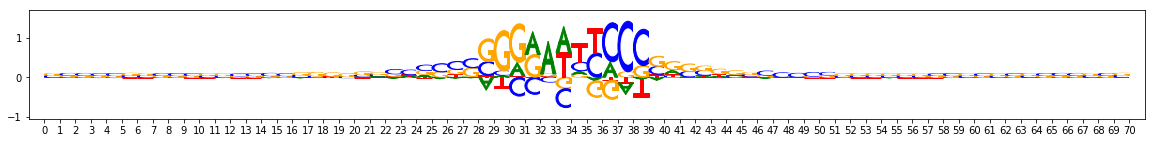

Task 0 actual importance scores:


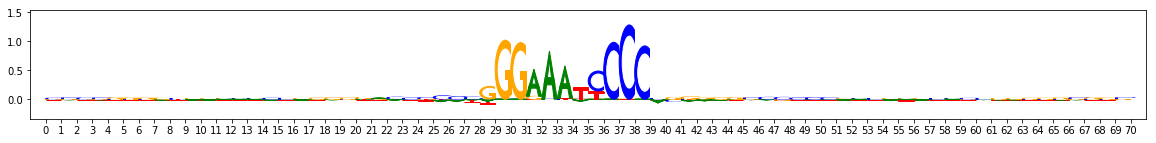

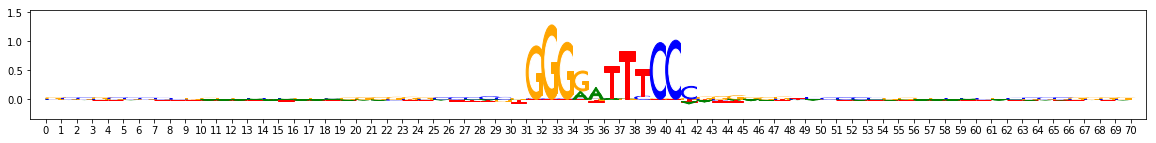

Task 1 hypothetical scores:


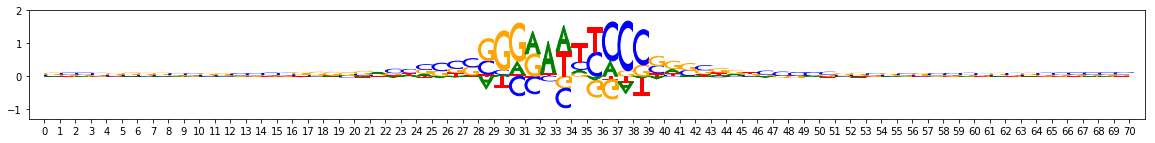

Task 1 actual importance scores:


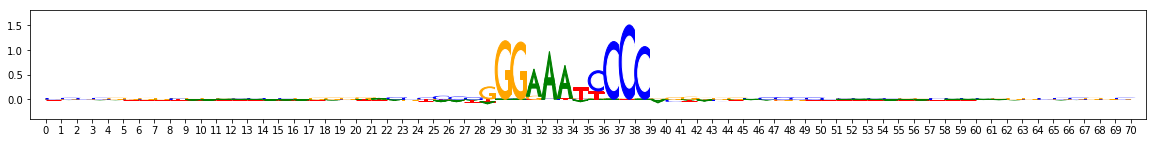

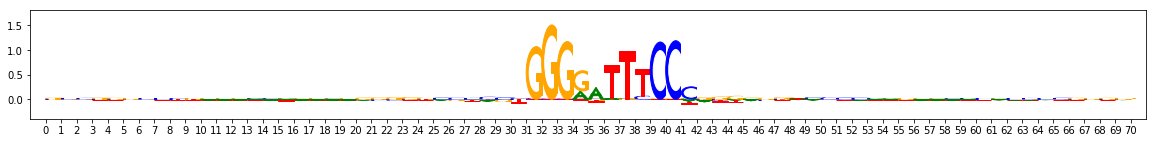

Task 2 hypothetical scores:


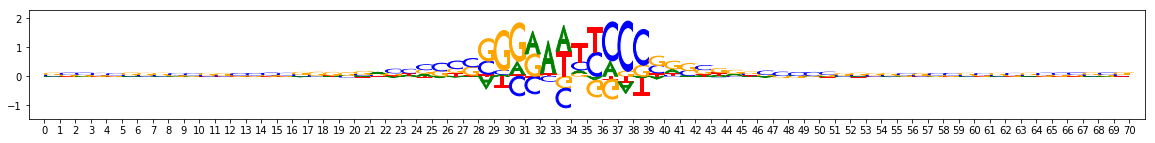

Task 2 actual importance scores:


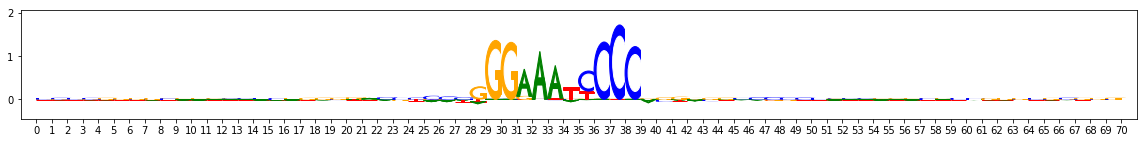

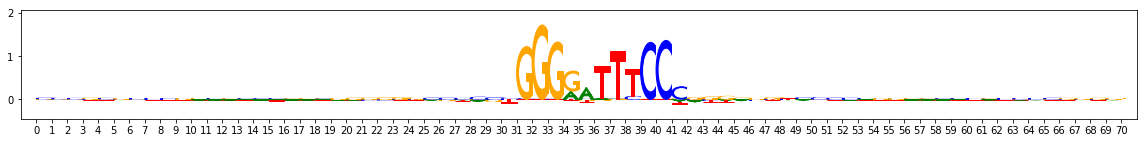

Task 3 hypothetical scores:


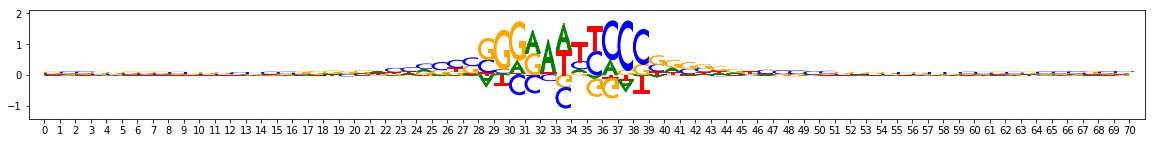

Task 3 actual importance scores:


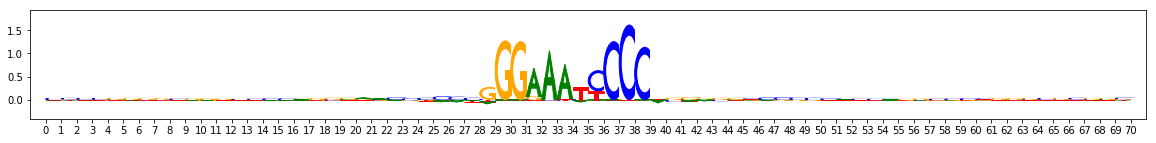

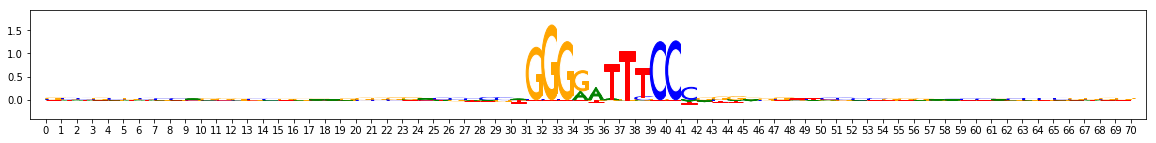

onehot, fwd and rev:


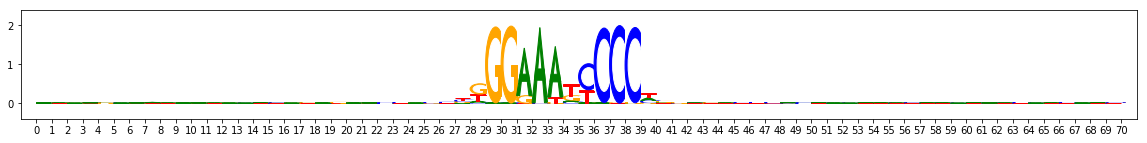

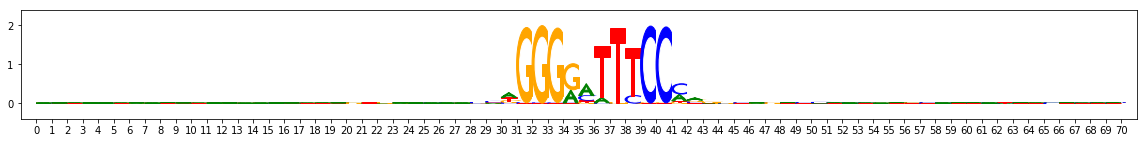

In [3]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        
        activity_pattern = metacluster_grp["activity_pattern"][:]
        for idx in range(len(activity_pattern)):
            if activity_pattern[idx] == 0:
                continue
            print("Task " + str(idx) + " hypothetical scores:")
            viz_sequence.plot_weights(pattern["task"+ str(idx) +"_hypothetical_contribs"]["fwd"])
            print("Task " + str(idx) + " actual importance scores:")
            viz_sequence.plot_weights(pattern["task" + str(idx) + "_contrib_scores"]["fwd"])
            viz_sequence.plot_weights(pattern["task" + str(idx) + "_contrib_scores"]["rev"])
        
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()